##### Partners for this homework are:
1. Pinaki Bhagat
2. Sydney Correa  
We tried couple of approaches for this homework to find out whether Shakespeare wrote all his 36 plays.
First Approach - Using text mining to find out which plays are similar

In this approach we tried the following steps:
a. Download the file and group by all plays to determine the unique plays for our analysis. We found
that there are 36 plays in the dataset.  
b. Basic cleansing of the line spoken by the player. This was done to remove all numbers and special
characters from the lines. We also converted all the line spoken by players into lower case.  
c. Tokenize the line spoken by every player so that we can use it for next steps  
d. Remove stop words to make sure our analysis doesn&#39;t get influenced by these redundant words  
e. Use Portar Stemmer to stemmatize the words  
f. Find out lines spoken by each player  
g. Prepare a word cloud to visualize the highly occurring words and further enhance the stop word step to remove highly occurring words  
h. Prepare a dictionary of words per play to be used for vectorizer step  
i. Use count vectorizer to extract the feature vector at a play level  
j. Perform tf-idf on this feature vector to obtain a normalized metrics for similarity measure  
k. Perform cosine similarity measure to determine the similar plays based on tf-idf metrics for all plays  
Shortcomings of this approach - We didn&#39;t have enough time to debug the issues with dictionary.  
The corpus that we created was combining all tokens from every play and we didn&#39;t have a way to segregate it at a play level. Because of this we were not able to get the similarity metric for all plays.  

Second Approach - Using network graph to determine which plays are similar

Our idea with this approach was to plot the network graph for the entire play vs individual play and determine the player interaction to see if all plays are having similar level of interactions.   

We tried the following steps in this approach:
a. Combine all plays together and determine the interactions of plays with all the players  
b. Generate graph for play versus player interactions  
c. Generate centrality measures for these player interactions.  
d. At a play level determine the interaction of players. For this we analyzed the Player who was speaking the lines and try to relate to which all players he/she was interacting in a line  
e. Generate a dataframe with these play interactions and perform basis cleaning  
f. Generate graph of the interactions  
g. Generate centrality measures for these player interactions.  
Shortcomings of this approach - Although interactions of plays and players gave us good picture of player interactions but, at a play level we were not able to establish  

# Importing std libraries

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models.ldamodel import LdaModel
# NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
import re


from sklearn.feature_extraction.text import CountVectorizer

C:\Users\corre\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Installing and importing CLTK library for old english stop words

In [ ]:
# !pip install CLTK
from cltk.stop.old_english.stops import STOPS_LIST as sl
from cltk.stop.middle_english.stops import STOPS_LIST as sl1


# Reading from csv into dataset

In [3]:
data_sh = pd.read_csv('C:\\Users\\corre\\Desktop\\CSCI E-82\\PS 6\\input\\Shakespeare_data.csv')

In [4]:
#sample dataset rows
data_sh.head()

Dataline      Play  PlayerLinenumber ActSceneLine         Player  \
0         1  Henry IV               NaN          NaN            NaN   
1         2  Henry IV               NaN          NaN            NaN   
2         3  Henry IV               NaN          NaN            NaN   
3         4  Henry IV               1.0        1.1.1  KING HENRY IV   
4         5  Henry IV               1.0        1.1.2  KING HENRY IV   

                                          PlayerLine  
0                                              ACT I  
1                       SCENE I. London. The palace.  
2  Enter KING HENRY, LORD JOHN OF LANCASTER, the ...  
3             So shaken as we are, so wan with care,  
4         Find we a time for frighted peace to pant,

# Data Analysis

In [129]:
##check the number of plays in the dataset

print('Number of plays - ', data_sh['Play'].nunique())
sorted(data_sh['Play'].unique())

Number of plays -  36


['A Comedy of Errors',
 'A Midsummer nights dream',
 'A Winters Tale',
 'Alls well that ends well',
 'Antony and Cleopatra',
 'As you like it',
 'Coriolanus',
 'Cymbeline',
 'Hamlet',
 'Henry IV',
 'Henry V',
 'Henry VI Part 1',
 'Henry VI Part 2',
 'Henry VI Part 3',
 'Henry VIII',
 'Julius Caesar',
 'King John',
 'King Lear',
 'Loves Labours Lost',
 'Measure for measure',
 'Merchant of Venice',
 'Merry Wives of Windsor',
 'Much Ado about nothing',
 'Othello',
 'Pericles',
 'Richard II',
 'Richard III',
 'Romeo and Juliet',
 'Taming of the Shrew',
 'The Tempest',
 'Timon of Athens',
 'Titus Andronicus',
 'Troilus and Cressida',
 'Twelfth Night',
 'Two Gentlemen of Verona',
 'macbeth']

In [130]:
## count number of 
data_sh.groupby('Play').count().sort_values(by='PlayerLine',ascending=False)['PlayerLine']

Play
Hamlet                      4244
Coriolanus                  3992
Cymbeline                   3958
Richard III                 3941
Antony and Cleopatra        3862
King Lear                   3766
Othello                     3762
Troilus and Cressida        3711
A Winters Tale              3489
Henry VIII                  3419
Henry V                     3395
Henry VI Part 2             3334
Romeo and Juliet            3313
Henry IV                    3205
Henry VI Part 3             3138
Alls well that ends well    3083
Measure for measure         2998
Loves Labours Lost          2986
Henry VI Part 1             2983
Richard II                  2937
Merry Wives of Windsor      2831
As you like it              2822
Taming of the Shrew         2806
Merchant of Venice          2802
Julius Caesar               2771
King John                   2766
Titus Andronicus            2726
Much Ado about nothing      2704
Timon of Athens             2662
Twelfth Night               2648
Peric

In [17]:
## count number of lines per player
lines_per_player= data_sh.groupby(['Player']).count()
lines_per_player

Dataline  Play  PlayerLinenumber  ActSceneLine  PlayerLine
Player                                                                       
A Lord                    1     1                 1             1           1
A Patrician               4     4                 4             3           4
A Player                  4     4                 4             4           4
AARON                   375   375               375           356         375
ABERGAVENNY              18    18                18            18          18
ABHORSON                 21    21                21            19          21
ABRAHAM                   5     5                 5             5           5
ACHILLES                208   208               208           190         208
ADAM                     69    69                69            65          69
ADRIAN                   16    16                16            12          16
ADRIANA                 284   284               284           276         284
ADRIANO DE ARMADO       284   284               284           268         284
AEGEON                  150   150               150           147         150
AEMELIA                  75    75                75            73          75
AEMILIUS                 22    22                22            21          22
AENEAS                  153   153               153           145         153
AEdile                   16    16                16            16          16
AGAMEMNON               210   210               210           196         210
AGRIPPA                  65    65                65            61          65
AJAX                     94    94                94            84          94
ALBANY                  187   187               187           160         187
ALCIBIADES              175   175               175           163         175
ALENCON                  50    50                50            49          50
ALEXANDER                34    34                34            33          34
ALEXAS                   32    32                32            31          32
ALICE                    27    27                27            27          27
ALL                      58    58                58            49          58
ALONSO                  113   113               113           110         113
AMIENS                   40    40                40            37          40
ANDROMACHE               16    16                16            15          16
...                     ...   ...               ...           ...         ...
VIOLA                   359   359               359           337         359
VIRGILIA                 35    35                35            35          35
VOLTIMAND                23    23                23            22          23
VOLUMNIA                323   323               323           314         323
VOLUMNIUS                 4     4                 4             3           4
Vintner                   5     5                 5             4           5
Volsce                   20    20                20            20          20
WARWICK                 690   690               690           648         690
WESTMORELAND             82    82                82            79          82
WHITMORE                 21    21                21            19          21
WILLIAM                  13    13                13            11          13
WILLIAM PAGE             12    12                12            12          12
WILLIAM STAFFORD          7     7                 7             7           7
WILLIAMS                 73    73                73            70          73
WOODVILE                  5     5                 5             5           5
WORCESTER                 1     1                 1             1           1
Wall                     13    13                13            12          13
Watch                     2     2                 2             2           2
Watchman                 15    15        

# Data cleansing, tokenizing, stemming and stop words

In [7]:
# Removing numbers:
data_sh['PlayerLine'] = data_sh['PlayerLine'].map(lambda x: re.sub(r'\d+', '', str(x)))

# Removing special characters
data_sh['PlayerLine'] = data_sh['PlayerLine'].map(lambda x: re.sub(r'[-.,;()\@?$%]', '', str(x)))

# Converting to lower case:
data_sh['PlayerLine'] = data_sh['PlayerLine'].map(lambda x: x.lower())
print(data_sh['PlayerLine'][2][:5000])

enter king henry lord john of lancaster the earl of westmoreland sir walter blunt and others


In [8]:
data_sh['PlayerLine'] = data_sh['PlayerLine'].map(lambda x: RegexpTokenizer(r'\w+').tokenize(x))
print(data_sh['PlayerLine'][2])

['enter', 'king', 'henry', 'lord', 'john', 'of', 'lancaster', 'the', 'earl', 'of', 'westmoreland', 'sir', 'walter', 'blunt', 'and', 'others']


In [146]:
stop_en = set(stopwords.words('english'))
stop_en = stop_en.union(sl, sl1)  # add some stopwords
stop_en = stop_en.union(['come','like','hath','know','may','man','men','must','go','upon','see','enter','good','let','lord','make','shall','sir','well', 'say','one','much','take','man'])

stopped_doc_tokens = []
for doc in data_sh['PlayerLine']:
    stopped_doc_tokens.append([word for word in doc if not word in stop_en])
print(stopped_doc_tokens[2:20])
data_sh['PlayerLine']=stopped_doc_tokens

[['king', 'henri', 'john', 'lancast', 'earl', 'westmoreland', 'walter', 'blunt'], ['shaken', 'wan', 'care'], ['find', 'time', 'fright', 'peac', 'pant'], ['breath', 'shortwind', 'accent', 'new', 'broil'], ['commenc', 'strand', 'afar', 'remot'], ['thirsti', 'entranc', 'soil'], ['daub', 'lip', 'children', 'blood'], ['trench', 'war', 'channel', 'field'], ['brui', 'floweret', 'arm', 'hoof'], ['hostil', 'pace', 'oppo', 'eye'], ['meteor', 'troubl', 'heaven'], ['natur', 'substanc', 'bred'], ['late', 'meet', 'intestin', 'shock'], ['furiou', 'close', 'civil', 'butcheri'], ['mutual', 'wellbeseem', 'rank'], ['march', 'way', 'oppo'], ['acquaint', 'kindr', 'alli'], ['edg', 'war', 'illsheath', 'knife']]


In [147]:
print(stopped_doc_tokens[2:20])

[['king', 'henri', 'john', 'lancast', 'earl', 'westmoreland', 'walter', 'blunt'], ['shaken', 'wan', 'care'], ['find', 'time', 'fright', 'peac', 'pant'], ['breath', 'shortwind', 'accent', 'new', 'broil'], ['commenc', 'strand', 'afar', 'remot'], ['thirsti', 'entranc', 'soil'], ['daub', 'lip', 'children', 'blood'], ['trench', 'war', 'channel', 'field'], ['brui', 'floweret', 'arm', 'hoof'], ['hostil', 'pace', 'oppo', 'eye'], ['meteor', 'troubl', 'heaven'], ['natur', 'substanc', 'bred'], ['late', 'meet', 'intestin', 'shock'], ['furiou', 'close', 'civil', 'butcheri'], ['mutual', 'wellbeseem', 'rank'], ['march', 'way', 'oppo'], ['acquaint', 'kindr', 'alli'], ['edg', 'war', 'illsheath', 'knife']]


In [148]:
stopstem_doc_tokens = []
for doc in data_sh['PlayerLine']:
    stopstem_doc_tokens.append([PorterStemmer().stem(word) for word in doc])

print(len(stopstem_doc_tokens))
print(stopstem_doc_tokens[2])
data_sh['PlayerLine']=stopstem_doc_tokens

111396
['king', 'henri', 'john', 'lancast', 'earl', 'westmoreland', 'walter', 'blunt']


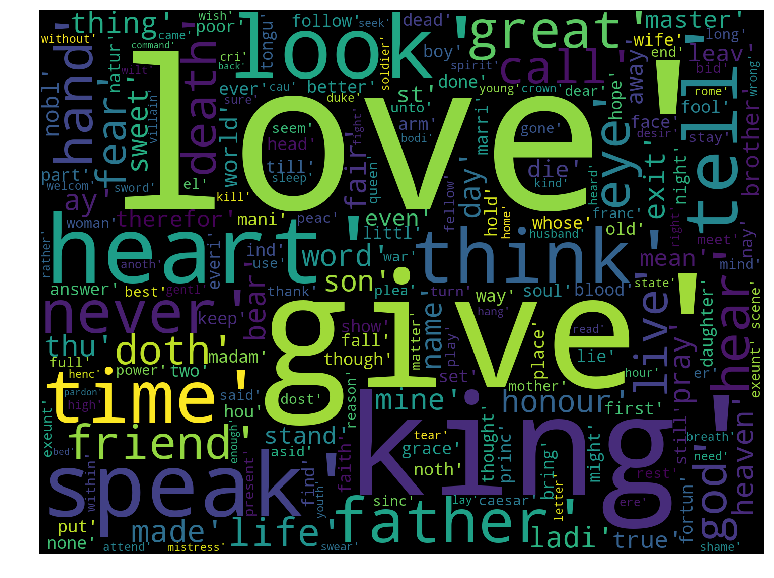

In [149]:
# Plot using wordcloud to visualize relative significance of words
from wordcloud import WordCloud
train_qs = pd.Series(data_sh["PlayerLine"].tolist()).astype(str)
qs_text = " ".join(train_qs)
cloud = WordCloud(width=1440, height=1080).generate(qs_text)
plt.figure(figsize=(15, 10))
plt.imshow(cloud);
plt.axis('off');

# Step1: Creating a Bag of Words corpus

In [143]:
def lines_to_words( raw_review ):
    return( " ".join( raw_review ))

In [21]:
num_lines = data_sh["PlayerLine"].size

# Initialize an empty list to hold the clean reviews
clean_player_lines = []

# Loop over each review; create an index i that goes from 0 to the length
# of the player lines 
for i in range( 0, num_lines ):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    clean_player_lines.append( lines_to_words( data_sh["PlayerLine"][i] ) )


In [22]:
clean_player_lines[1:25]

['scene london palac',
 'king henri john lancast earl westmoreland walter blunt other',
 'shaken wan care',
 'find time fright peac pant',
 'breath shortwind accent new broil',
 'commenc strand afar remot',
 'thirsti entranc soil',
 'daub lip children blood',
 'trench war channel field',
 'bruis floweret arm hoof',
 'hostil pace oppos eye',
 'like meteor troubl heaven',
 'one natur one substanc bred',
 'late meet intestin shock',
 'furiou close civil butcheri',
 'mutual wellbeseem rank',
 'march one way oppos',
 'acquaint kindr alli',
 'edg war like illsheath knife',
 'cut master therefor friend',
 'far sepulchr christ',
 'whose soldier whose bless cross',
 'impress engag fight',
 'forthwith power english levi']

In [23]:
es=pd.Series(clean_player_lines)
data_sh['PlayerLine_clean'] = es.values

# Creating a DictVectorizer

In [97]:
#create unique list of names 
UniqueNames = data_sh.Play.unique()
for x in UniqueNames:
    DataFrameDict.update({'Play':x})

DataFrameDict

{'Play': (35, 'A Winters Tale')}

In [72]:
DataFrameDict = {elem : data_sh['PlayerLine_clean'] for elem in UniqueNames}

In [73]:
DataFrameDict

{'Henry IV': 0                                                       act
 1                                        scene london palac
 2         king henri john lancast earl westmoreland walt...
 3                                           shaken wan care
 4                                find time fright peac pant
 5                         breath shortwind accent new broil
 6                                 commenc strand afar remot
 7                                      thirsti entranc soil
 8                                   daub lip children blood
 9                                  trench war channel field
 10                                  bruis floweret arm hoof
 11                                    hostil pace oppos eye
 12                                like meteor troubl heaven
 13                              one natur one substanc bred
 14                                 late meet intestin shock
 15                              furiou close civil butcheri
 16         

In [36]:
for key in DataFrameDict.keys(): DataFrameDict[key] = data_sh[:][data_sh.Play == key]

In [24]:
#d1=data_sh.set_index('Play').T.to_dict('List')
d= dict(data_sh.groupby('Play')['PlayerLine_clean'].apply(list))

In [65]:
d['Henry IV']

['act',
 'scene london palac',
 'king henri john lancast earl westmoreland walter blunt other',
 'shaken wan care',
 'find time fright peac pant',
 'breath shortwind accent new broil',
 'commenc strand afar remot',
 'thirsti entranc soil',
 'daub lip children blood',
 'trench war channel field',
 'bruis floweret arm hoof',
 'hostil pace oppos eye',
 'like meteor troubl heaven',
 'one natur one substanc bred',
 'late meet intestin shock',
 'furiou close civil butcheri',
 'mutual wellbeseem rank',
 'march one way oppos',
 'acquaint kindr alli',
 'edg war like illsheath knife',
 'cut master therefor friend',
 'far sepulchr christ',
 'whose soldier whose bless cross',
 'impress engag fight',
 'forthwith power english levi',
 'whose arm mould mother womb',
 'chase pagan holi field',
 'whose acr walk bless feet',
 'fourteen hundr year ago nail',
 'advantag bitter cross',
 'purpos twelv month old',
 'bootless tell go',
 'therefor meet hear',
 'gentl cousin westmoreland',
 'yesternight council

In [27]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()

pos_vectorized = vec.fit_transform(d)
pos_vectorized

ValueError: could not convert string to float: 'act'

# Trying a countVectorizer (instead)

In [155]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 5000) 


##since passing the entire dict object is not giving the correct feature vector
#trying to pass one dict key (Play) at a time

# Play 1
train_data_features = vectorizer.fit_transform(d['Julius Caesar'])
vocab = vectorizer.get_feature_names()
# Play 2 
train_data_features1 = vectorizer.fit_transform(d['Henry IV'])
vocab1 = vectorizer.get_feature_names()
# Play 3 
train_data_features2 = vectorizer.fit_transform(d['Hamlet'])
vocab1 = vectorizer.get_feature_names()



# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features2.toarray()

In [157]:
train_data_features2.shape

(4244, 3548)

In [158]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print(vocab)

['abat', 'abhor', 'abil', 'abl', 'aboard', 'abomin', 'abridg', 'abroad', 'absent', 'absolut', 'abstin', 'abstract', 'absurd', 'abus', 'accent', 'accept', 'access', 'accid', 'accident', 'accord', 'account', 'accurst', 'accus', 'ach', 'achiev', 'acquaint', 'acquir', 'acr', 'act', 'action', 'actionsoft', 'activ', 'actor', 'acurs', 'adam', 'adder', 'addict', 'addit', 'address', 'adher', 'adieu', 'adjoin', 'admir', 'admit', 'admitt', 'adopt', 'adown', 'adowna', 'adulter', 'advanc', 'advantag', 'adventur', 'advic', 'advis', 'aenea', 'aeri', 'afar', 'afeard', 'affair', 'affect', 'afflict', 'affright', 'affront', 'afoot', 'afraid', 'afternoon', 'afterward', 'age', 'ago', 'agre', 'ah', 'aid', 'aim', 'air', 'airi', 'ala', 'alack', 'alarm', 'alexand', 'allegi', 'alley', 'allow', 'almost', 'alon', 'along', 'aloof', 'alreadi', 'altitud', 'altogeth', 'alway', 'amak', 'amaz', 'ambassador', 'amber', 'ambigu', 'ambit', 'ambiti', 'ambl', 'amen', 'amiss', 'amiti', 'anchor', 'ancient', 'ancl', 'andwould',

In [161]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    if count>50:
        print(count, tag)

71 father
69 give
72 go
111 hamlet
62 hath
53 heaven
98 king
82 know
86 like
84 love
57 man
70 may
60 must
65 say
52 see
69 speak
53 think
51 time
57 upon


# Using Tf-IDF on the corpus

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_corpus=data_sh.iloc[:,[1,6]]


tf = TfidfVectorizer(analyzer='word', ngram_range=(1,4), min_df = 0)
#tfidf_matrix =  tf.fit_transform(tf_corpus)
#tfidf_matrix = tf.fit_transform(d['Julius Caesar'])
tfidf_matrix = tf.fit_transform(vocab)


In [63]:
tfidf_matrix.shape

<2126x2126 sparse matrix of type '<class 'numpy.float64'>'
	with 2126 stored elements in Compressed Sparse Row format>

In [54]:
from sklearn.metrics.pairwise import linear_kernel

def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]

In [64]:
find_similar(tfidf_matrix,2)

[(2125, 0.0), (705, 0.0), (711, 0.0), (710, 0.0), (709, 0.0)]

# Switching to trying graphs (instead of NLP vectorizers)

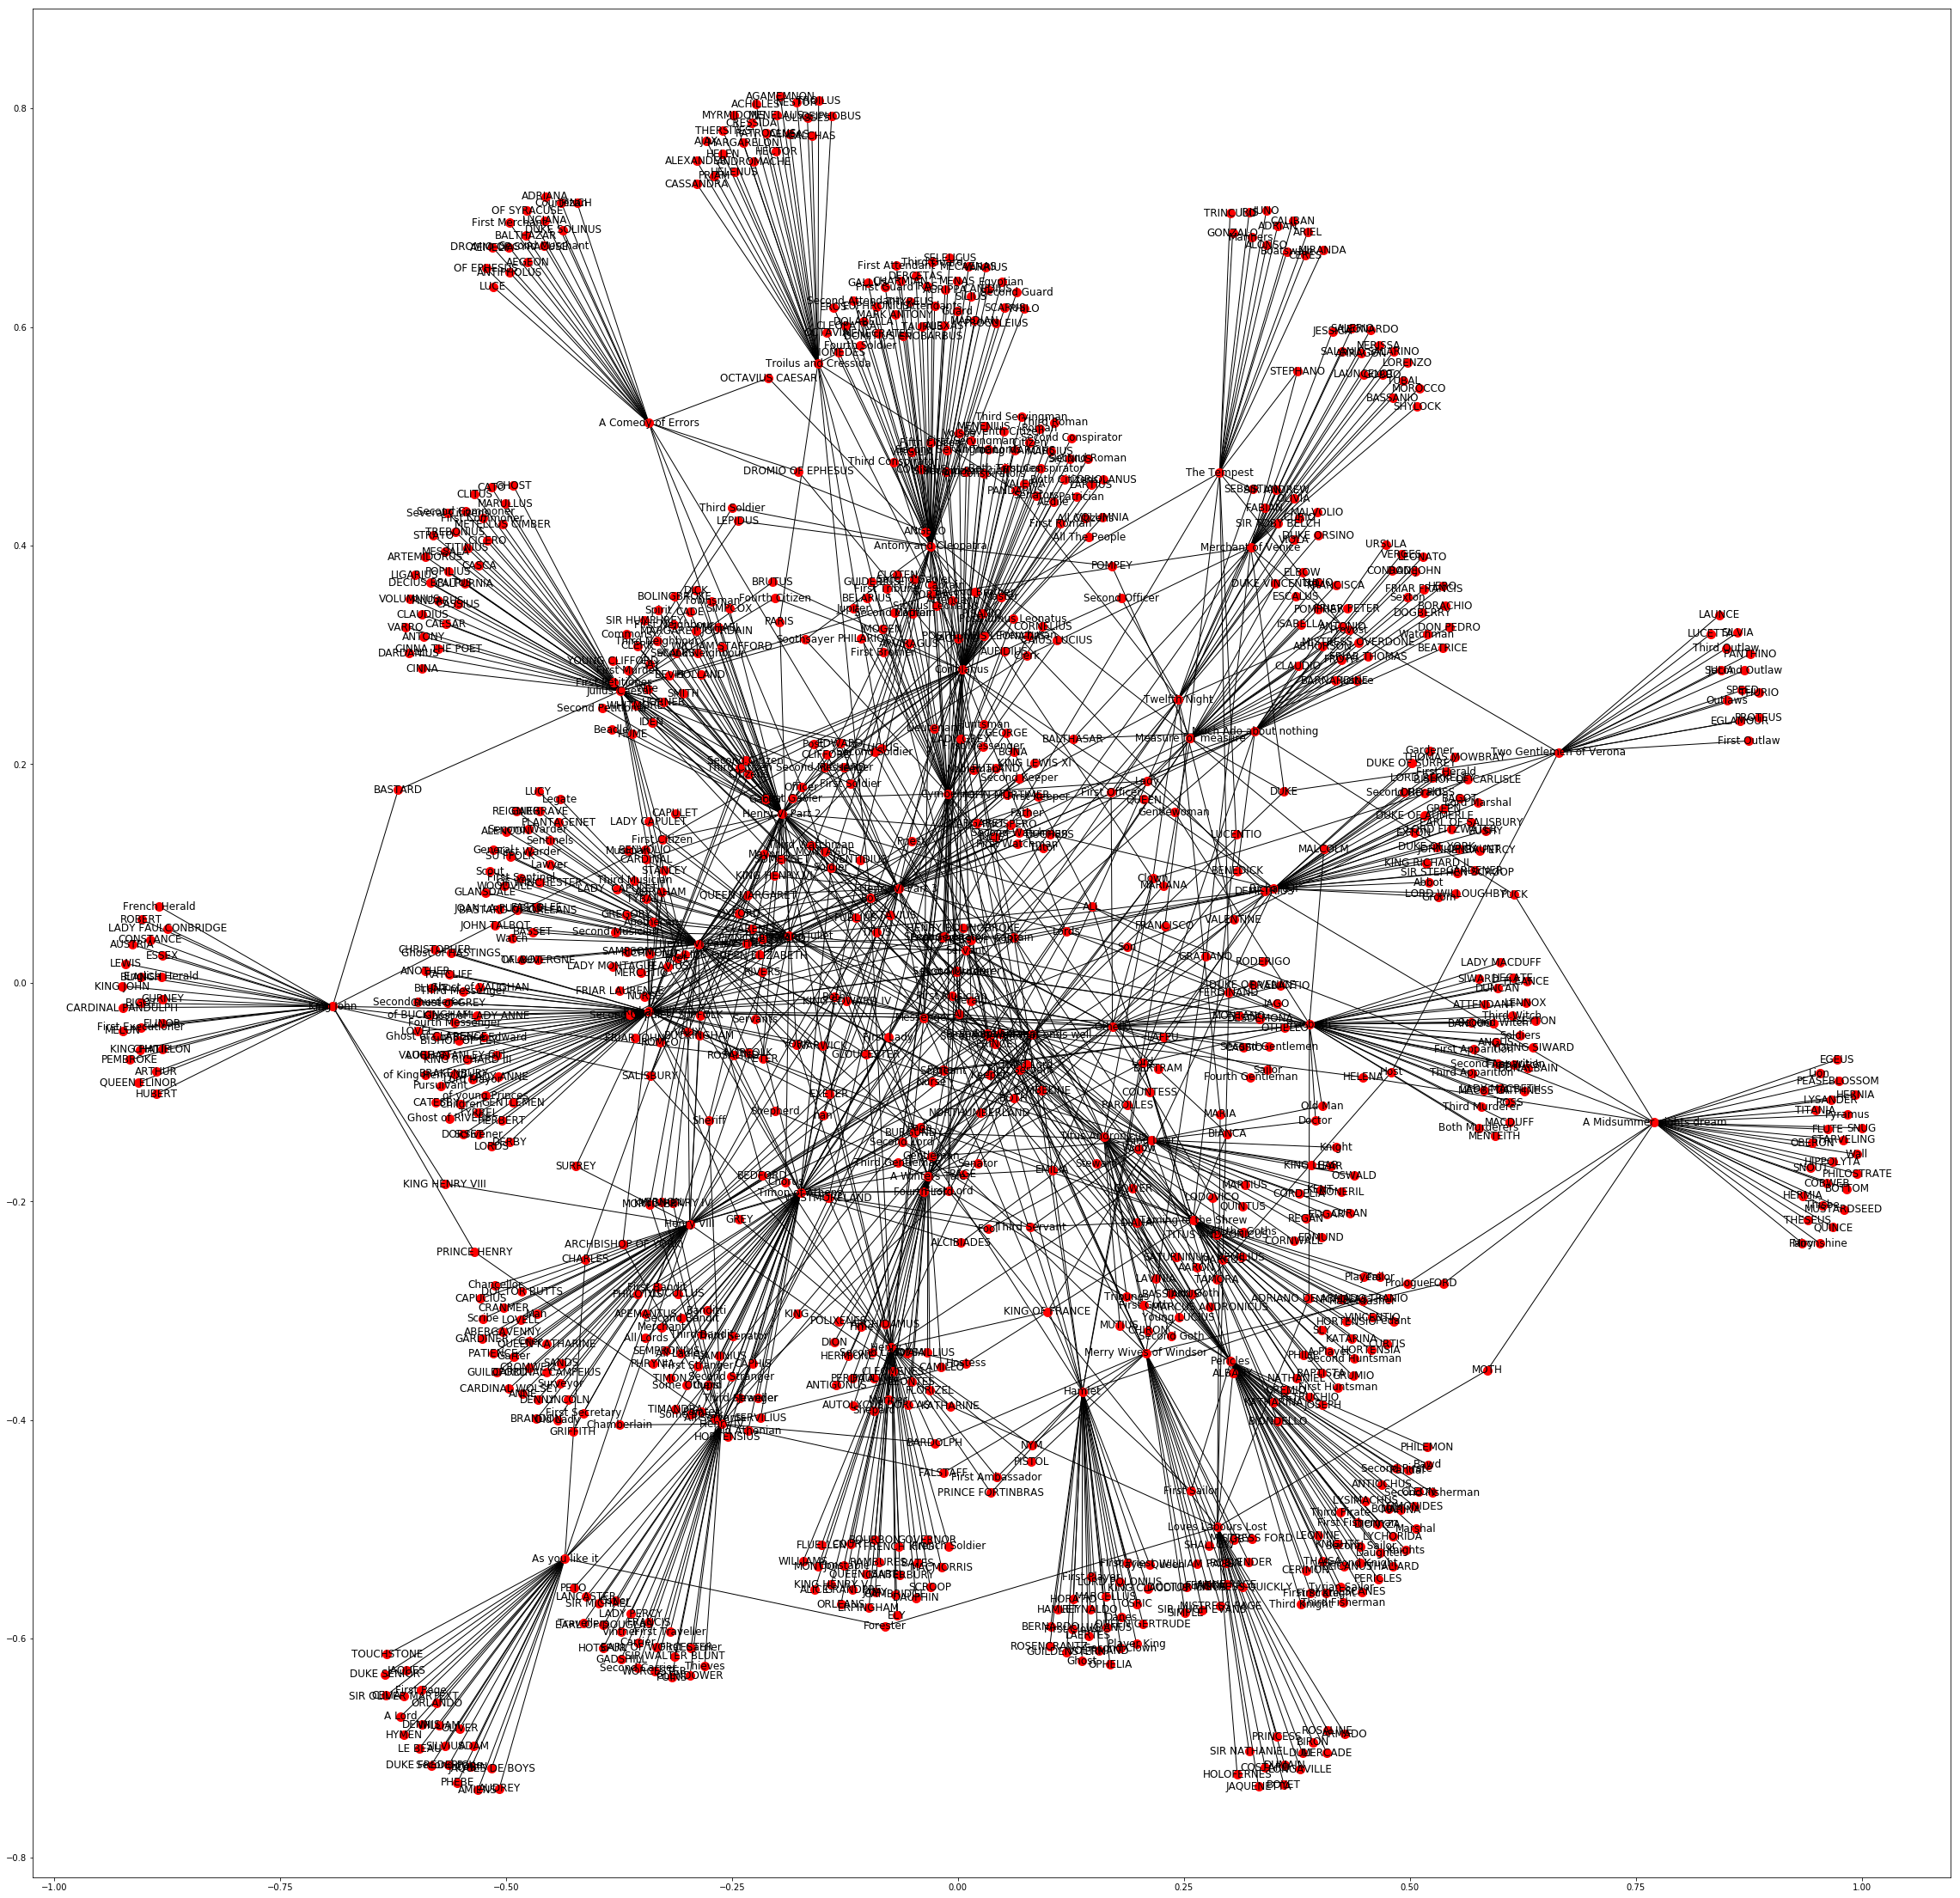

In [102]:

## Play vs player graph
## for all plays

g = nx.from_pandas_edgelist(data_sh,source='Play',target='Player')
plt.figure(figsize=(40,40)) 
nx.draw_networkx(g,with_labels=True,node_size=100)
plt.show()

In [117]:
## removing NaaN as it throws errors with centrality
data_sh['Player'].replace(np.nan, 'Other',inplace = True)
data_sh['ActSceneLine'].replace(np.nan, '0',inplace = True)

# Graph of Player vs Player

In [118]:
from itertools import combinations
#create unique list of names
UniqueNames = data_sh.Play.unique()

In [119]:
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}

In [120]:
for key in DataFrameDict.keys():
    DataFrameDict[key] = data_sh[:][data_sh.Play == key]

In [121]:
f = lambda x : pd.DataFrame(list(combinations(x.values,2)), columns=['Player1','Player2'])

In [122]:
pairs = (DataFrameDict['A Midsummer nights dream'].groupby('ActSceneLine')['Player'].apply(f).reset_index(level=1, drop=True).reset_index())

In [123]:
pairs_clean = pairs
for x in range(pairs_clean.Player1.count()):
    if (pairs_clean.Player1[x]== pairs_clean.Player2[x]):
            pairs_clean.drop(x,inplace=True)

In [126]:
g1= nx.from_pandas_edgelist(pairs_clean,source='Player1',target='Player2')

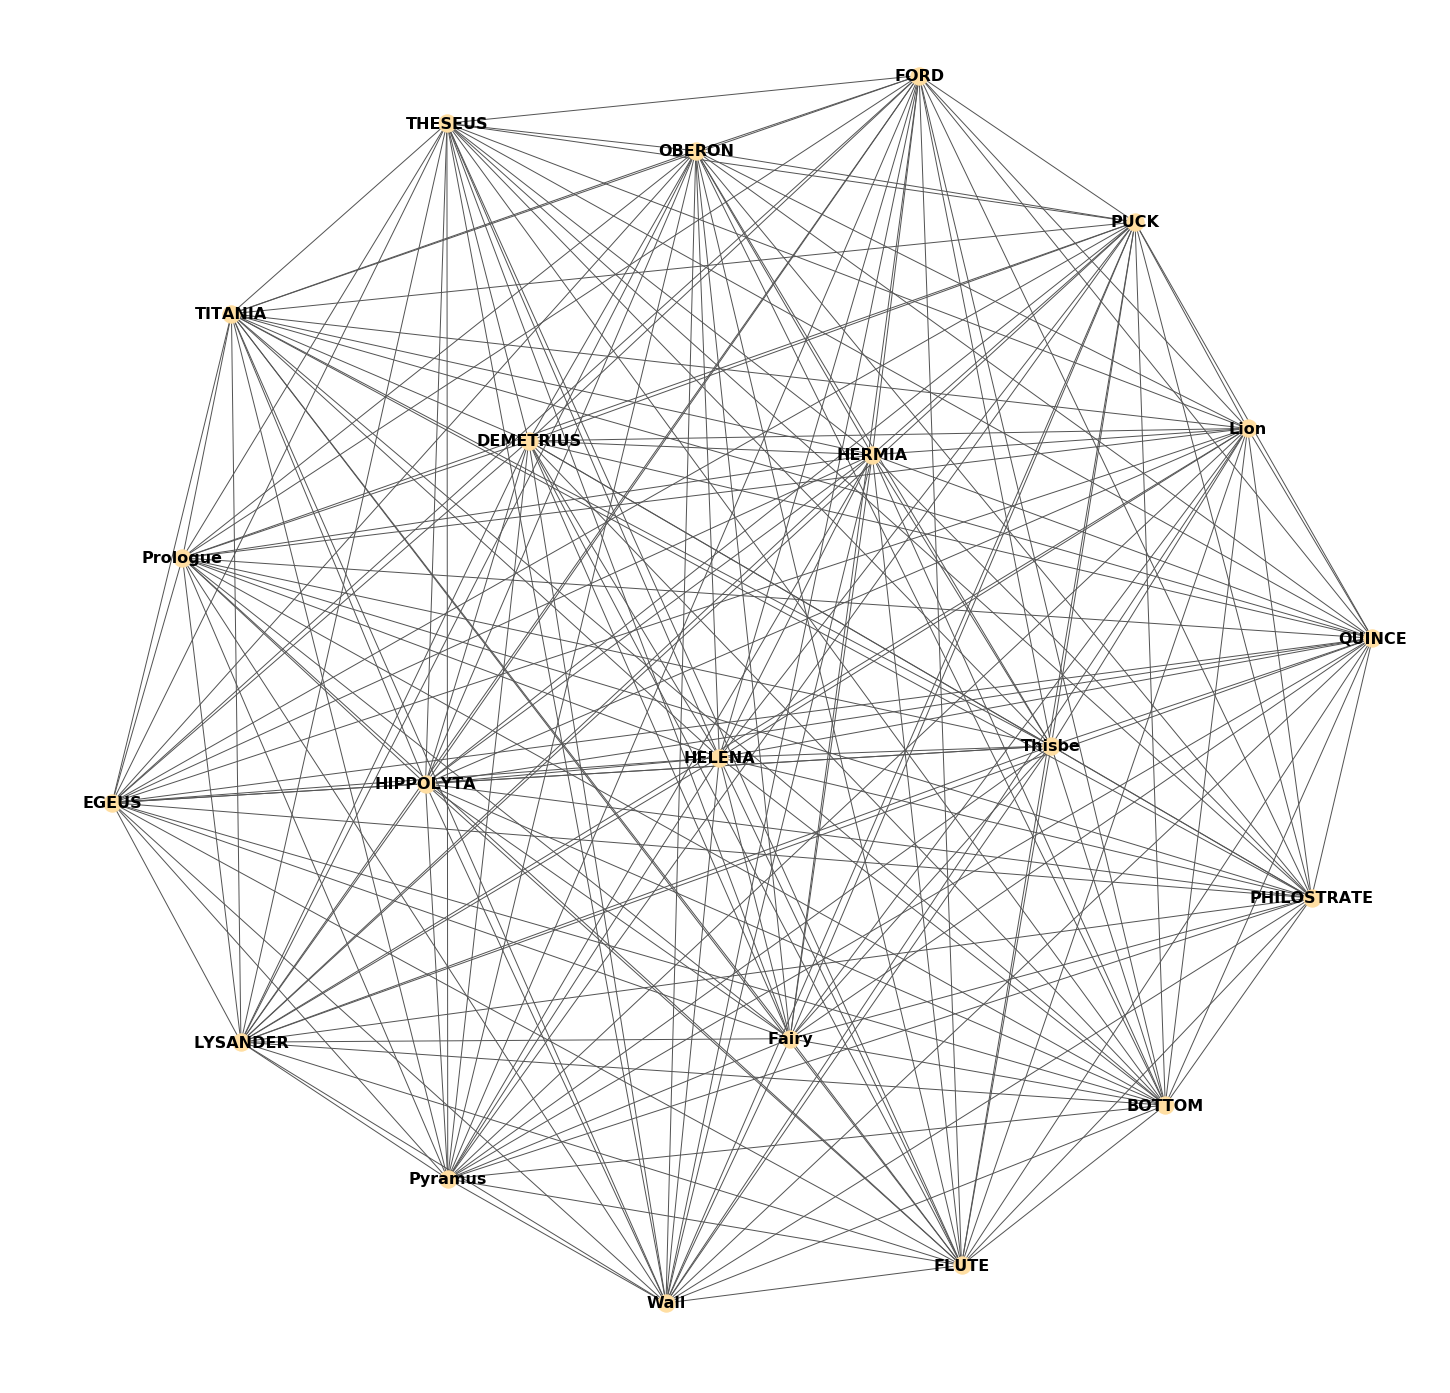

In [127]:
plt.figure(figsize=(25,25))
options = {
    'edge_color': '#555555',
    'width': 1,
    'with_labels': True, 
    'node_color': '#FFDEA2',
    'font_weight': 'bold',
    'font_size':16
}
nx.draw_networkx(g1,   pos=nx.spring_layout(g1, k=0.5, iterations=50), **options)
ax = plt.gca()
ax.set_axis_off()
plt.show()

# Checking centrality and other measures

In [125]:
centralMeasures = pd.DataFrame(nx.degree_centrality(g1),index=[0]).T
centralMeasures.columns=['Degree Centrality']
centralMeasures['Closeness centrality']= pd.DataFrame(nx.closeness_centrality(g1),index=[0]).T
centralMeasures['Betweenness centrality']= pd.DataFrame(nx.betweenness_centrality(g1),index=[0]).T
centralMeasures['Eigenvector centrality']= pd.DataFrame(nx.eigenvector_centrality(g1),index=[0]).T
centralMeasures['Page Rank']= pd.DataFrame(nx.pagerank(g1),index=[0]).T
centralMeasures['Name']= centralMeasures.index.tolist()
centralMeasures.index = np.arange(0,len(centralMeasures))
centralMeasures.sort_values(by=['Degree Centrality'], ascending=False).head(25)

Degree Centrality  Closeness centrality  Betweenness centrality  \
0                 1.0                   1.0                     0.0   
11                1.0                   1.0                     0.0   
19                1.0                   1.0                     0.0   
18                1.0                   1.0                     0.0   
17                1.0                   1.0                     0.0   
16                1.0                   1.0                     0.0   
15                1.0                   1.0                     0.0   
14                1.0                   1.0                     0.0   
13                1.0                   1.0                     0.0   
12                1.0                   1.0                     0.0   
10                1.0                   1.0                     0.0   
1                 1.0                   1.0                     0.0   
9                 1.0                   1.0                     0.0   
8                 1.0                   1.0                     0.0   
7                 1.0                   1.0                     0.0   
6                 1.0                   1.0                     0.0   
5                 1.0                   1.0                     0.0   
4                 1.0                   1.0                     0.0   
3                 1.0                   1.0                     0.0   
2                 1.0                   1.0                     0.0   
20                1.0                   1.0                     0.0   

    Eigenvector centrality  Page Rank         Name  
0                 0.218218   0.047619         FORD  
11                0.218218   0.047619    DEMETRIUS  
19                0.218218   0.047619         Lion  
18                0.218218   0.047619         Wall  
17                0.218218   0.047619       Thisbe  
16                0.218218   0.047619      Pyramus  
15                0.218218   0.047619     Prologue  
14                0.218218   0.047619  PHILOSTRATE  
13                0.218218   0.047619        FLUTE  
12                0.218218   0.047619       QUINCE  
10                0.218218   0.047619       HERMIA  
1                 0.218218   0.047619      THESEUS  
9                 0.218218   0.047619        Fairy  
8                 0.218218   0.047619       OBERON  
7                 0.218218   0.047619         PUCK  
6                 0.218218   0.047619      TITANIA  
5                 0.218218   0.047619       BOTTOM  
4                 0.218218   0.047619       HELENA  
3                 0.218218   0.047619     LYSANDER  
2                 0.218218   0.047619        EGEUS  
20                0.218218   0.047619    HIPPOLYTA